# Exercise: Splitting a dataset to assess a model

We normally build models to make predictions. It's important to check that the predictions a model makes are reasonable before we assume it is ready for real world use. Like a human student, we test a model on data it has never seen before.

Recall our farming scenario. In this exercise, we will build a basic model that looks to see if global warming has changed the environment we have been growing onions in. 

As a first step, we will split a dataset into _training_ and _test_ datasets. We will fit the model to the training dataset, and then run inference on (make predictions for) the test dataset. We will use this to evaluate how well our model might work when given weather data for future years.

## Inspecting our weather data

Let's begin by opening publicly available weather data for Seattle

In [1]:
import pandas

# Load a file containing weather data for seattle
data = pandas.read_csv('Data/seattleWeather_1948-2017.csv', parse_dates=['date'])

# Print the first and last few rows
data

,date,amount_of_precipitation,max_temperature,min_temperature,rain
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True
...,...,...,...,...,...
25546,2017-12-10,0.00,49,34,False
25547,2017-12-11,0.00,49,29,False
25548,2017-12-12,0.00,46,32,False
25549,2017-12-13,0.00,48,34,False


It looks like we have data from 1948 to 2017, split across more than 25k rows. If we want to ever see how many rows and columns without this large print out, we can simply inspect data's `shape`. Lets practice this, restricting ourselves to temperature readings between January and July, when people normally plant onions.

In [2]:
# Remove all dates after July 1st because we have to to plant onions before summer begins
data = data[[d.month < 7 for d in data.date]].copy()

# print out how much data we have left.
data.shape

(12688, 5)

Looks like we still have over 12k rows left.

We will be analysing the relationship between `date` and daily minimum temperatures. To do this, we need to convert each date into a simple number (year) that the computer can understand it better.


Visual Check:


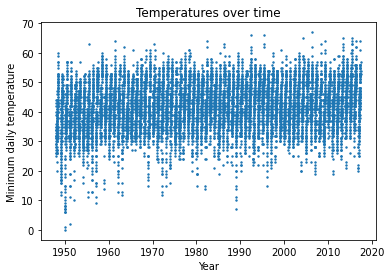

In [3]:
import matplotlib.pyplot as graph
from datetime import datetime
from dateutil import relativedelta

# Convert the dates into numbers so we can use it in our models
# We make a year column which can contain fractions. For example
# 1948.5 is half way through the year 1948
data["year"] = [(d.year + d.timetuple().tm_yday / 365.25) for d in data.date]

# Let's take a quick look at our data
# Don't worry about how this is done for now
print("\nVisual Check:")
%matplotlib inline
graph.scatter(data.year, data.min_temperature, s=2)
graph.ylabel('Minimum daily temperature (°F)')
graph.xlabel("Year")
graph.title('Temperatures over time')
graph.show()


There's certainly a lot of data there. Much more than we can make sense of without some help.

## Split dataset into training and testing sets

First, lets split the dataset into training and testing sets. The training dataset will be used to fit the model. The testing dataset will be used to check how well it works on unseen data.

We will perform as 80/20 split, which means 80% of the data is randomly allocated to the training dataset, and the remaining 20% is allocated to the test dataset.

In [4]:
from sklearn.model_selection import train_test_split

# Split our dataset into two, called train and test.
# test_size here states that we want 20% of the data to be
# in the 'test' dataset, and the remainder in the 'train' 
# dataset. We set random_state here so that the random allocation 
# is reproducible
train, test = train_test_split(data, test_size=0.2, random_state=0)

# Print out how this has been split
print(f"We started with {data.shape[0]} rows. After splitting:")
print(f"train contains {train.shape[0]} rows")
print(f"test contains {test.shape[0]} rows")

We started with 12688 rows. After splitting:
train contains 10150 rows
test contains 2538 rows


We've now randomly allocated our measurements into _training_ and _test_ datasets. 

In a real-world situation using data that changes by time you might consider allocating entire months or years of data to one set or the other, but for the sake of learning we've just kept this simple. 

## Create and visualise the model

Let's create our model using the training data. We will fit a linear regession model. This tries to model the data using the equation `y = mx + c`, where:
* `y` is the daily minimum temperature
* `x` is the date
* `m` and `c` are calculated during fitting. 

In [5]:
import statsmodels.formula.api as smf

# Fit a simple model that finds a linear relationship
# between date (as a number) and temperature
model = smf.ols(formula = "min_temperature ~ year", data = train).fit()
print("Model trained!")

# Print the model
intercept = model.params[0]
slope = model.params[1]

print(f"The model is: y = {slope} * x + {intercept}")

Model trained!
The model is: y = 0.06377196327698029 * x + -84.69254387378575
C:\Users\leere\Anaconda3\envs\ml_crash_course\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


That's interesting - it looks like temperatures have been increasing about 0.064°F per year.

That means, since 1950, the winter temperatures near our farm have increased about 4.5°F (2.5°C).

Before we overhaul our farming practices, let's double check the model is working sensibly. 

## Test Performance On Training Data

When we first fit our model, we usually want to check how well it has run on the training dataset. Specifically:

 1. Does it generate predictions at all? I.E. do we have errors in our code?
 2. Are the predictions **reasonably** close to the values we expect?

We can do this a number of ways, for example:

1. Print out some predictions alongside the real (expected) values
2. Graph the model, if possible
3. Calculate an error metric that summarises how well predictions fit the expected results 

The code below creates a function that uses the model to predict values, then runs (1) and (2) from the list above. We will cover error metrics in another unit.

       Predicted  Expected
12150  41.656651        40
13307  41.858792        48
20194  43.061206        45
16484  42.413360        23
23448  43.629392        33
8189   40.965112        55
21677  43.320135        49
4516   40.323900        45
25203  43.935681        28
20926  43.188924        40

Visual Check:


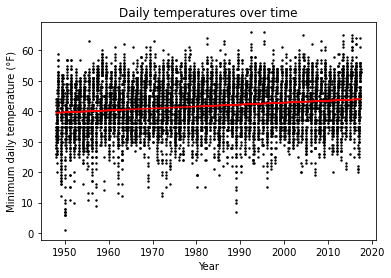

In [8]:
from sklearn.metrics import mean_squared_error


def assess_model(dataframe):
    '''
    This uses the model to predict temperatures from a 
    supplied dataframe.
    These predictions are then compared to the 
    expected temperatures that appear in the dataframe by: 
    (a) printing them alongside each other, and 
    (b) produces a graph to visually check the model in 
        the context of the original data.  

    dataframe: A dataframe containing columns for 
    'years' and 'min_temperature'
    '''

    # Calculate the predicted values for the test data 
    predicted_temperatures = model.predict(dataframe)

    # Make and print a table showing some expected (real)
    # values alongside predicted ones
    results_dataset = pandas.DataFrame({
        'Predicted': predicted_temperatures[:10], 
        'Expected': dataframe.min_temperature[:10]
        })
    print(results_dataset)

    # Show a graph of the result
    print("\nVisual Check:")
    line = slope * dataframe.year + intercept
    graph.scatter(dataframe.year, dataframe.min_temperature, s=2, color='black')
    graph.plot(dataframe.year, line, '-', c = 'red')
    graph.ylabel('Minimum daily temperature (°F)')
    graph.xlabel("Year")
    graph.title('Daily temperatures over time')
    graph.show()

# Run and assess the model using the data it was trained on
assess_model(train)

The model (red line) seems to follow the average temperatures reasonably well, though it's not fantastic at predicting temperatures on any particular day. That can be expected; daily temperatures vary quite a lot.

## Test Performance on Test data

We expected the model to do a reasonable job on training data, but what we are more interested in is how well it does on data it has not seen before. This will be indicative of how well it might work when predicting temperatures in the near future.

Let's now run and assess the model using the test data

       Predicted  Expected
18072  42.690621        51
17659  42.618643        43
18655  42.792499        37
20132  43.050381        37
15845  42.301879        51
16214  42.366349        48
13901  41.962416        40
12204  41.666080        51
11105  41.474240        48
14257  42.024617        33

Visual Check:


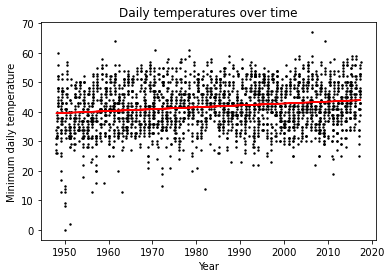

In [7]:
assess_model(test)

We can see that it did a reasonable job, so we can have confidence in our model.

Given that temperatures have been changing, we might want to consider re-thinking the date we plant our crops!

## Summary

In this exercise, we practiced splitting data into _test_ and _training_ datasets. We then trained our model on one dataset, then tested it on another. This is an exercise you become used to with time, as it is the most common way to assess how well our models appear to be working.